In [1]:
 from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import cv2
import imutils
import numpy as np
import matplotlib.pyplot as plt
import time
from os import listdir

%matplotlib inline

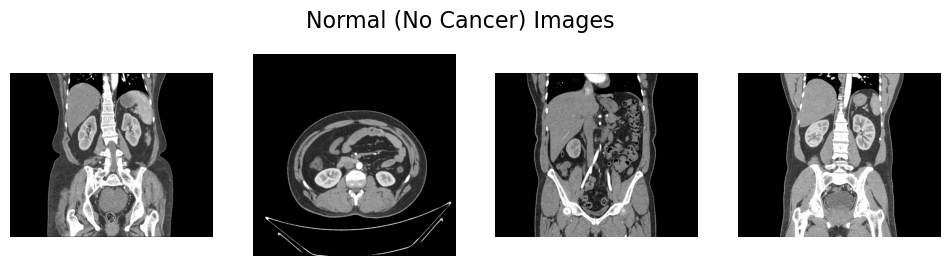

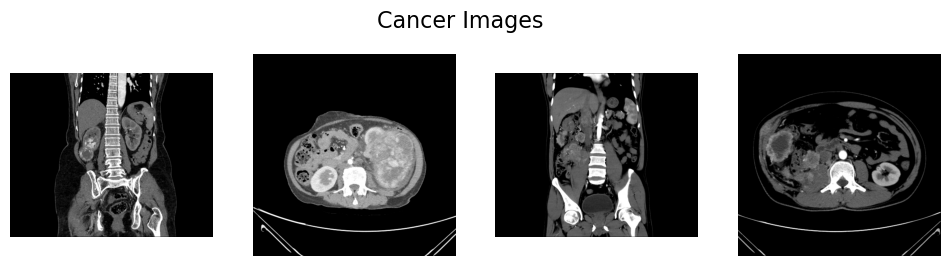

Total 'Normal (No Cancer)' images: 5077
Total 'Cancer' images: 2283


In [2]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

# Define dataset paths
dataset_path = r"C:\Users\pc\Downloads\kidney-cancer\kidney-Mri\Dataset"
cancer_path = os.path.join(dataset_path, 'Cancer')  
normal_path = os.path.join(dataset_path, 'Normal')   

# Check if folders exist
if not os.path.exists(cancer_path) or not os.path.exists(normal_path):
    print("Error: One or both dataset folders do not exist.")
else:
    # Get unique images from each folder
    cancer_files = list(set(os.listdir(cancer_path)))  # Remove duplicates
    normal_files = list(set(os.listdir(normal_path)))  # Remove duplicates

    # Shuffle to pick random different images
    random.shuffle(cancer_files)
    random.shuffle(normal_files)

    # Select up to 4 unique images
    cancer_images = cancer_files[:4] if len(cancer_files) >= 4 else cancer_files
    normal_images = normal_files[:4] if len(normal_files) >= 4 else normal_files

    # Convert filenames to full file paths
    cancer_images = [os.path.join(cancer_path, img) for img in cancer_images]
    normal_images = [os.path.join(normal_path, img) for img in normal_images]

    # Function to display images
    def display_images(image_paths, title):
        if not image_paths:
            print(f"No images found for {title}.")
            return
        
        fig, axes = plt.subplots(1, len(image_paths), figsize=(12, 3))
        fig.suptitle(title, fontsize=16)

        for ax, img_path in zip(axes, image_paths):
            try:
                img = mpimg.imread(img_path)
                ax.imshow(img)
                ax.axis("off")
            except FileNotFoundError:
                print(f"File not found: {img_path}")

        plt.show()

    # Display images
    display_images(normal_images, "Normal (No Cancer) Images")
    display_images(cancer_images, "Cancer Images")

    # Print total count of images
    print(f"Total 'Normal (No Cancer)' images: {len(normal_files)}")
    print(f"Total 'Cancer' images: {len(cancer_files)}")


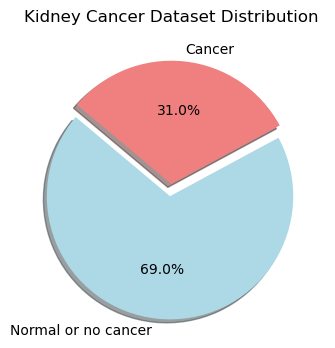

In [3]:
import os
import matplotlib.pyplot as plt

# Define dataset paths
no_path = r"C:\Users\pc\Downloads\kidney-cancer\kidney-Mri\Dataset\Normal"
yes_path = r"C:\Users\pc\Downloads\kidney-cancer\kidney-Mri\Dataset\Cancer"

# Count total images in each category
no_count = len(os.listdir(no_path))
yes_count = len(os.listdir(yes_path))

# Labels and sizes for the pie chart
labels = ['Normal or no cancer ', 'Cancer']
sizes = [no_count, yes_count]
colors = ['lightblue', 'lightcoral']
explode = (0.1, 0)  # Highlight the 'No Cancer' category

# Create pie chart
plt.figure(figsize=(4, 4))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, explode=explode, shadow=True, startangle=140)
plt.title("Kidney Cancer Dataset Distribution")

# Show the chart
plt.show()


In [4]:
def crop_kidney_contour(image, plot=False):

    import cv2
    import imutils
    from matplotlib import pyplot as plt
    
    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    

    # Find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    if plot:
        plt.figure()

        plt.subplot(1, 2, 1)
        plt.imshow(image)
        
        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        
        plt.title('Original Image')
            
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)

        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Cropped Image')
        
        plt.show()
    
    return new_image

    

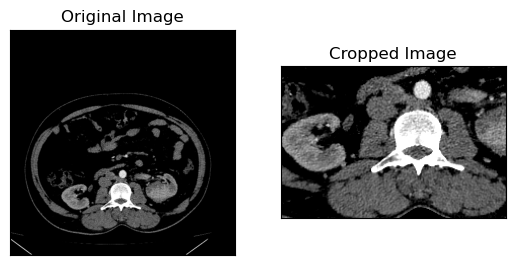

In [5]:
image_path = r"C:\Users\pc\Downloads\kidney-cancer\kidney-Mri\Dataset\Cancer\Cancer (1).jpg"

ex_img = cv2.imread(image_path)

if ex_img is not None:
    ex_new_img = crop_kidney_contour(ex_img, True)
else:
    print("Error: Image not loaded. Check the path.")


In [6]:
import cv2
import numpy as np
from os import listdir
import os
from sklearn.utils import shuffle

def crop_kidney_contour(image, plot=False):
    import matplotlib.pyplot as plt

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    _, thresh = cv2.threshold(blurred, 45, 255, cv2.THRESH_BINARY)

    kernel = np.ones((5, 5), np.uint8)
    thresh = cv2.erode(thresh, kernel, iterations=2)
    thresh = cv2.dilate(thresh, kernel, iterations=2)

    contours, _ = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if len(contours) == 0:
        return image

    c = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(c)
    cropped = image[y:y+h, x:x+w]

    if plot:
        plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title("Original")
        plt.subplot(1, 2, 2)
        plt.imshow(cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB))
        plt.title("Cropped")
        plt.show()

    return cropped

def load_data(dir_list, image_size=(240, 240)):
    X = []
    y = []
    image_width, image_height = image_size

    for directory in dir_list:
        folder_name = os.path.basename(directory).lower()
        label = 1 if "cancer" in folder_name else 0

        for filename in listdir(directory):
            image_path = os.path.join(directory, filename)
            image = cv2.imread(image_path)

            if image is None:
                continue

            image = crop_kidney_contour(image)
            image = cv2.resize(image, (image_width, image_height), interpolation=cv2.INTER_AREA)
            image = image / 255.0

            X.append(image)
            y.append([label])

    X = np.array(X, dtype=np.float32)
    y = np.array(y, dtype=np.int32)
    X, y = shuffle(X, y)

    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')
    print("Label distribution:", dict(zip(*np.unique(y, return_counts=True))))

    return X, y


In [7]:
def load_data(dir_list, image_size):
    """
    Read images, resize, and normalize them. 
    Arguments:
        dir_list: list of strings representing file directories.
    Returns:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    """

    X = []
    y = []
    image_width, image_height = image_size

    for directory in dir_list:
        label = 1 if 'Cancer' in directory.split("\\")[-1] else 0  # Explicitly check folder name

        for filename in listdir(directory):
            image_path = directory + '\\' + filename
            image = cv2.imread(image_path)

            if image is None:
                continue

            # Crop kidney region
            image = crop_kidney_contour(image, plot=False)

            # Resize and normalize
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_AREA)
            image = image / 255.

            X.append(image)
            y.append([label])  # Use label based on folder name

    # Convert to numpy arrays (with memory efficiency)
    X = np.array(X, dtype=np.float32)
    y = np.array(y)

    X, y = shuffle(X, y)

    print(f'Number of examples is: {len(X)}')
    print(f'X shape is: {X.shape}')
    print(f'y shape is: {y.shape}')

    return X, y


In [8]:
augmented_cancer = r"C:\Users\pc\Downloads\kidney-cancer\kidney-Mri\Dataset\Cancer"
augmented_normal = r"C:\Users\pc\Downloads\kidney-cancer\kidney-Mri\Dataset\Normal"

IMG_WIDTH, IMG_HEIGHT = (240, 240)

X, y = load_data([augmented_cancer, augmented_normal], (IMG_WIDTH, IMG_HEIGHT))


Number of examples is: 7360
X shape is: (7360, 240, 240, 3)
y shape is: (7360, 1)


In [9]:
import matplotlib.pyplot as plt
import numpy as np

def plot_sample_images(X, y, n=50):
    """
    Plots n sample images for both values of y (labels).
    Arguments:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    """
    for label in [0, 1]:
        indices = np.argwhere(y == label).flatten()  # ✅ flatten avoids extra dimension
        selected_indices = indices[:n]
        n_images = X[selected_indices]

        columns_n = 10
        rows_n = int(np.ceil(n / columns_n))

        plt.figure(figsize=(20, 5))
        for i, img in enumerate(n_images):
            plt.subplot(rows_n, columns_n, i + 1)
            plt.imshow(img)
            plt.axis('off')

        label_str = "Cancer" if label == 1 else " ( Normal: No Cancer)"
        plt.suptitle(f"kidney Cancer: {label_str}")
        plt.tight_layout()
        plt.show()


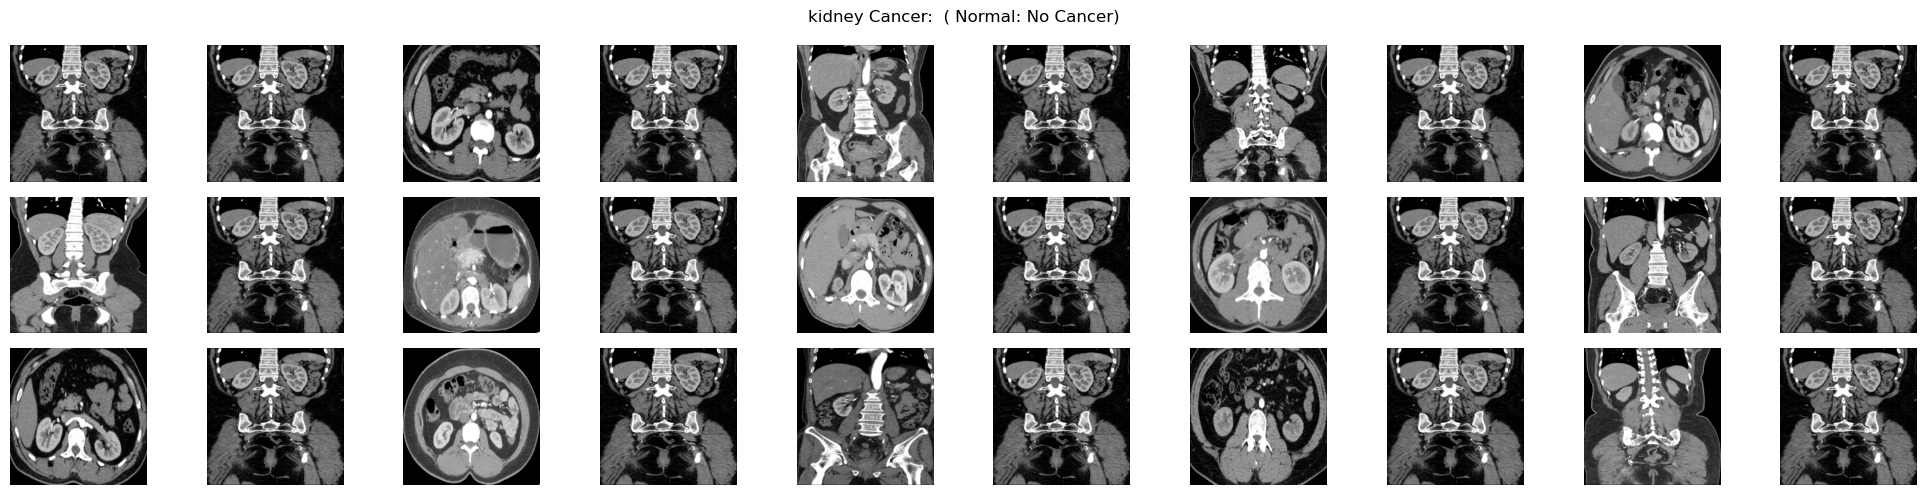

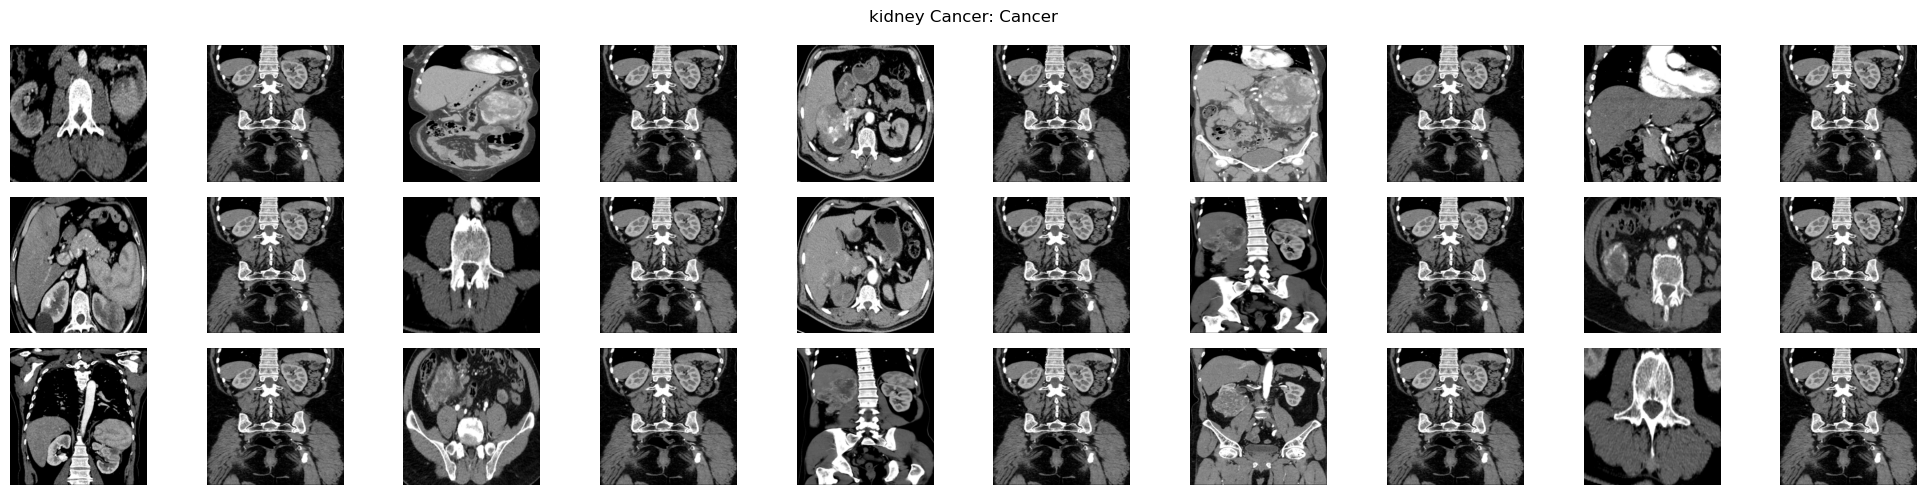

In [10]:
plot_sample_images(X, y, n=30)  # you can reduce n to save memory


In [11]:
from sklearn.model_selection import train_test_split

def split_data(X, y, test_size=0.2):
    
    """
    Splits data into training, validation, and test sets.
    """
    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=test_size)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5)

    return X_train, y_train, X_val, y_val, X_test, y_test


In [12]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, test_size=0.3)

In [13]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of development examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(y_train.shape))
print ("X_val (dev) shape: " + str(X_val.shape))
print ("Y_val (dev) shape: " + str(y_val.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(y_test.shape))

number of training examples = 5152
number of development examples = 1104
number of test examples = 1104
X_train shape: (5152, 240, 240, 3)
Y_train shape: (5152, 1)
X_val (dev) shape: (1104, 240, 240, 3)
Y_val (dev) shape: (1104, 1)
X_test shape: (1104, 240, 240, 3)
Y_test shape: (1104, 1)


In [14]:
# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m}:{round(s,1)}"

In [15]:
def compute_f1_score(y_true, prob):
    # convert the vector of probabilities to a target vector
    y_pred = np.where(prob > 0.5, 1, 0)
    
    score = f1_score(y_true, y_pred)
    
    return score

In [16]:
def build_model(input_shape):
    """
    Arugments:
        input_shape: A tuple representing the shape of the input of the model. shape=(image_width, image_height, #_channels)
    Returns:
        model: A Model object.
    """
    # Define the input placeholder as a tensor with shape input_shape. 
    X_input = Input(input_shape) # shape=(?, 240, 240, 3)
    
    # Zero-Padding: pads the border of X_input with zeroes
    X = ZeroPadding2D((2, 2))(X_input) # shape=(?, 244, 244, 3)
    
    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(32, (7, 7), strides = (1, 1), name = 'conv0')(X)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X) # shape=(?, 238, 238, 32)
    
    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool0')(X) # shape=(?, 59, 59, 32) 
    
    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool1')(X) # shape=(?, 14, 14, 32)
    
    # FLATTEN X 
    X = Flatten()(X) # shape=(?, 6272)
    # FULLYCONNECTED
    X = Dense(1, activation='sigmoid', name='fc')(X) # shape=(?, 1)
    
    # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs = X_input, outputs = X, name='KidneyDetectionModel')
    
    return model

In [17]:
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)

In [18]:
model = build_model(IMG_SHAPE)

In [19]:
model.summary()

Model: "KidneyDetectionModel"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 240, 240, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ zero_padding2d (ZeroPadding2D)       │ (None, 244, 244, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv0 (Conv2D)                       │ (None, 238, 238, 32)        │           4,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bn0 (BatchNormalization)             │ (None, 238, 238, 32)        │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 238, 238, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pool0 (MaxPooling2D)             │ (None, 59, 59, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pool1 (MaxPooling2D)             │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc (Dense)                           │ (None, 1)                   │           6,273 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,137 (43.50 KB)

 Trainable params: 11,073 (43.25 KB)

 Non-trainable params: 64 (256.00 B)

In [20]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [21]:
# tensorboard
log_file_name = f'kidney_cancer_detection_cnn_{int(time.time())}'
tensorboard = TensorBoard(log_dir=f'logs/{log_file_name}')

In [22]:
# checkpoint
# unique file name that will include the epoch and the validation (development) accuracy
filepath = "models/cnn-parameters-improvement-{epoch:02d}-{val_accuracy:.2f}.keras"
# save the model with the best validation (development) accuracy till now
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

In [23]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=10, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7436 - loss: 0.8117
Epoch 1: val_accuracy improved from -inf to 0.92663, saving model to models/cnn-parameters-improvement-01-0.93.keras
161/161 ━━━━━━━━━━━━━━━━━━━━ 351s 2s/step - accuracy: 0.7442 - loss: 0.8094 - val_accuracy: 0.9266 - val_loss: 0.3221
Epoch 2/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 31s/step - accuracy: 0.9420 - loss: 0.1723 
Epoch 2: val_accuracy improved from 0.92663 to 0.96558, saving model to models/cnn-parameters-improvement-02-0.97.keras
161/161 ━━━━━━━━━━━━━━━━━━━━ 4942s 31s/step - accuracy: 0.9420 - loss: 0.1722 - val_accuracy: 0.9656 - val_loss: 0.1446
Epoch 3/10
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9745 - loss: 0.0927
Epoch 3: val_accuracy improved from 0.96558 to 0.97645, saving model to models/cnn-parameters-improvement-03-0.98.keras
161/161 ━━━━━━━━━━━━━━━━━━━━ 175s 1s/step - accuracy: 0.9745 - loss: 0.0927 - val_accuracy: 0.9764 - val_loss: 0.0937
Epoch 4/10
161/161 ━━━━━━━━━━━

In [24]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=3, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time() 
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/3
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.0053
Epoch 1: val_accuracy did not improve from 0.99728
161/161 ━━━━━━━━━━━━━━━━━━━━ 171s 1s/step - accuracy: 1.0000 - loss: 0.0053 - val_accuracy: 0.9955 - val_loss: 0.0280
Epoch 2/3
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.0050
Epoch 2: val_accuracy did not improve from 0.99728
161/161 ━━━━━━━━━━━━━━━━━━━━ 199s 1s/step - accuracy: 1.0000 - loss: 0.0050 - val_accuracy: 0.9955 - val_loss: 0.0163
Epoch 3/3
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.0039
Epoch 3: val_accuracy improved from 0.99728 to 0.99819, saving model to models/cnn-parameters-improvement-03-1.00.keras
161/161 ━━━━━━━━━━━━━━━━━━━━ 171s 1s/step - accuracy: 1.0000 - loss: 0.0039 - val_accuracy: 0.9982 - val_loss: 0.0139
Elapsed time: 0:9:6.3


In [25]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=3, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/3
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.0032
Epoch 1: val_accuracy did not improve from 0.99819
161/161 ━━━━━━━━━━━━━━━━━━━━ 170s 1s/step - accuracy: 1.0000 - loss: 0.0032 - val_accuracy: 0.9982 - val_loss: 0.0134
Epoch 2/3
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.0026
Epoch 2: val_accuracy did not improve from 0.99819
161/161 ━━━━━━━━━━━━━━━━━━━━ 169s 1s/step - accuracy: 1.0000 - loss: 0.0026 - val_accuracy: 0.9982 - val_loss: 0.0124
Epoch 3/3
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.0025
Epoch 3: val_accuracy did not improve from 0.99819
161/161 ━━━━━━━━━━━━━━━━━━━━ 174s 1s/step - accuracy: 1.0000 - loss: 0.0025 - val_accuracy: 0.9973 - val_loss: 0.0150
Elapsed time: 0:8:34.5


In [26]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=3, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/3
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.0020
Epoch 1: val_accuracy did not improve from 0.99819
161/161 ━━━━━━━━━━━━━━━━━━━━ 171s 1s/step - accuracy: 1.0000 - loss: 0.0020 - val_accuracy: 0.9982 - val_loss: 0.0134
Epoch 2/3
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.0017
Epoch 2: val_accuracy did not improve from 0.99819
161/161 ━━━━━━━━━━━━━━━━━━━━ 171s 1s/step - accuracy: 1.0000 - loss: 0.0017 - val_accuracy: 0.9982 - val_loss: 0.0120
Epoch 3/3
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.0014
Epoch 3: val_accuracy did not improve from 0.99819
161/161 ━━━━━━━━━━━━━━━━━━━━ 171s 1s/step - accuracy: 1.0000 - loss: 0.0014 - val_accuracy: 0.9982 - val_loss: 0.0136
Elapsed time: 0:8:34.3


In [27]:
start_time = time.time()

model.fit(x=X_train, y=y_train, batch_size=32, epochs=5, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

end_time = time.time()
execution_time = (end_time - start_time)
print(f"Elapsed time: {hms_string(execution_time)}")

Epoch 1/5
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.0012
Epoch 1: val_accuracy did not improve from 0.99819
161/161 ━━━━━━━━━━━━━━━━━━━━ 174s 1s/step - accuracy: 1.0000 - loss: 0.0012 - val_accuracy: 0.9982 - val_loss: 0.0125
Epoch 2/5
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 1.0000 - loss: 0.0013
Epoch 2: val_accuracy did not improve from 0.99819
161/161 ━━━━━━━━━━━━━━━━━━━━ 172s 1s/step - accuracy: 1.0000 - loss: 0.0013 - val_accuracy: 0.9964 - val_loss: 0.0240
Epoch 3/5
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9646 - loss: 0.1088
Epoch 3: val_accuracy did not improve from 0.99819
161/161 ━━━━━━━━━━━━━━━━━━━━ 199s 1s/step - accuracy: 0.9646 - loss: 0.1088 - val_accuracy: 0.9601 - val_loss: 0.1138
Epoch 4/5
161/161 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9965 - loss: 0.0129
Epoch 4: val_accuracy did not improve from 0.99819
161/161 ━━━━━━━━━━━━━━━━━━━━ 202s 1s/step - accuracy: 0.9965 - loss: 0.0129 - val_accuracy: 0.9964 - val_l

In [28]:
history = model.history.history

In [29]:
for key in history.keys():
    print(key)

accuracy
loss
val_accuracy
val_loss


In [30]:
def plot_metrics(history):
    
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_Accuracy = history['Accuracy']
    val_acc = history['val_acc']
    
    # Loss
    plt.figure()
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss')
    plt.legend()
    plt.show()
    
    # Accuracy
    plt.figure()
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.show()

In [31]:
import matplotlib.pyplot as plt

def plot_metrics(history):
    """
    Plots training and validation loss and accuracy curves.

    Args:
        history: The history object returned by model.fit(), or history.history (a dict).
    """
    # If the input is a Keras History object, extract .history
    if hasattr(history, 'history'):
        history = history.history

    train_loss = history['loss']
    val_loss = history['val_loss']
    
    # Support both 'accuracy' and 'acc' keys depending on Keras version
    if 'accuracy' in history:
        train_acc = history['accuracy']
        val_acc = history['val_accuracy']
    elif 'acc' in history:
        train_acc = history['acc']
        val_acc = history['val_acc']
    else:
        raise ValueError("Accuracy keys not found in history")

    # Plot Loss
    plt.figure(figsize=(7, 4))
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot Accuracy
    plt.figure(figsize=(8, 4))
    plt.plot(train_acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()


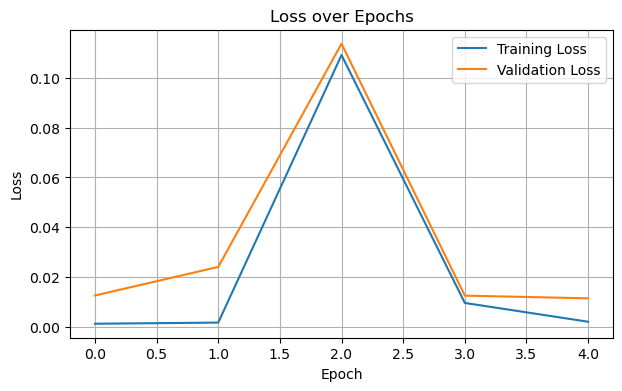

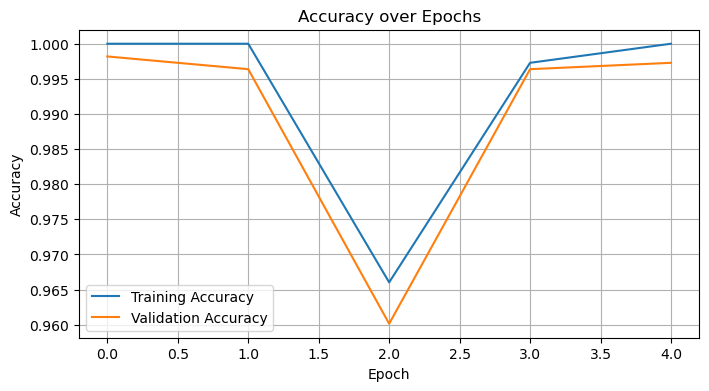

In [32]:
plot_metrics(history) 

In [33]:
from keras.models import load_model

best_model = load_model(r'C:\Users\pc\Desktop\models\cnn-parameters-improvement-02-0.96.keras')


In [34]:
best_model.metrics_names

['loss', 'compile_metrics']

In [35]:
loss, acc = best_model.evaluate(x=X_test, y=y_test)

35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 162ms/step - accuracy: 0.9748 - loss: 0.1044


In [36]:
print (f"Test Loss = {loss}")
print (f"Test Accuracy = {acc}")

Test Loss = 0.11306298524141312
Test Accuracy = 0.9737318754196167


In [37]:
y_test_prob = best_model.predict(X_test)

35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 171ms/step


In [38]:
f1score = compute_f1_score(y_test, y_test_prob)
print(f"F1 score: {f1score}")

F1 score: 0.9559939301972686


In [39]:
y_val_prob = best_model.predict(X_val)

35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 171ms/step


In [40]:
f1score_val = compute_f1_score(y_val, y_val_prob)
print(f"F1 score: {f1score_val}")

F1 score: 0.9254185692541856


In [41]:
def data_percentage(y):
    
    m=len(y)
    n_positive = np.sum(y)
    n_negative = m - n_positive
    
    pos_prec = (n_positive* 100.0)/ m
    neg_prec = (n_negative* 100.0)/ m
    
    print(f"Number of examples: {m}")
    print(f"Percentage of positive examples: {pos_prec}%, number of pos examples: {n_positive}") 
    print(f"Percentage of negative examples: {neg_prec}%, number of neg examples: {n_negative}") 

In [42]:
# the whole data
data_percentage(y)

Number of examples: 7360
Percentage of positive examples: 31.019021739130434%, number of pos examples: 2283
Percentage of negative examples: 68.98097826086956%, number of neg examples: 5077


In [43]:
print("Training Data:")
data_percentage(y_train)
print("Validation Data:")
data_percentage(y_val)
print("Testing Data:")
data_percentage(y_test)

Training Data:
Number of examples: 5152
Percentage of positive examples: 30.861801242236027%, number of pos examples: 1590
Percentage of negative examples: 69.13819875776397%, number of neg examples: 3562
Validation Data:
Number of examples: 1104
Percentage of positive examples: 31.884057971014492%, number of pos examples: 352
Percentage of negative examples: 68.1159420289855%, number of neg examples: 752
Testing Data:
Number of examples: 1104
Percentage of positive examples: 30.88768115942029%, number of pos examples: 341
Percentage of negative examples: 69.1123188405797%, number of neg examples: 763


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step


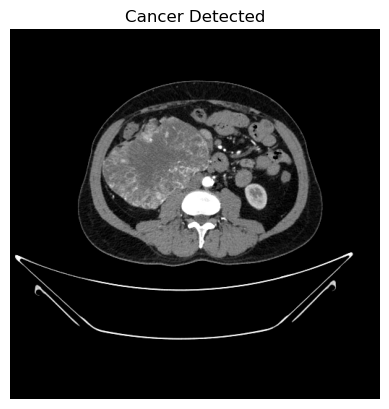

Prediction: Cancer (Probability: 0.87)


In [44]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
import imutils
from tensorflow.keras.models import load_model
from tkinter import Tk, filedialog

# Function to preprocess image
def preprocess_image(image_path, img_size=(240, 240)):
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError("Error loading image. Ensure the file is valid.")
    
    # Convert to grayscale and apply Gaussian Blur
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)
    
    # Thresholding to remove background noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)
    
    # Find contours and get the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    
    # Get extreme points and crop the brain area
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]
    image = cv2.resize(image, img_size)
    image = image / 255.0  # Normalize
    
    return image

# Function to test an uploaded image
def test_image(model_path):
    # Load trained model
    model = load_model(model_path)
    
    # Open file dialog to select an image
    Tk().withdraw()
    image_path = filedialog.askopenfilename(title="Select an MRI Image", filetypes=[("Image Files", "*.jpg;*.png;*.jpeg")])
    
    if not image_path:
        print("No image selected.")
        return
    
    # Preprocess the image
    image = preprocess_image(image_path)
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    
    # Predict
    prediction = model.predict(image)
    cancer_prob = prediction[0][0]  # Assuming a single output neuron
    
    # Display results
    plt.imshow(cv2.imread(image_path))
    plt.title("Cancer Detected" if cancer_prob > 0.5 else "No Cancer Detected")
    plt.axis('off')
    plt.show()
    
    print(f"Prediction: {'Cancer' if cancer_prob > 0.5 else 'No Cancer'} (Probability: {cancer_prob:.2f})")

# Example Usage
if __name__ == "__main__":
    test_image(r'C:\Users\pc\Desktop\models\cnn-parameters-improvement-02-0.96.keras')


Epoch 1/5
184/184 ━━━━━━━━━━━━━━━━━━━━ 2219s 12s/step - accuracy: 0.6829 - loss: 0.6081 - val_accuracy: 0.6685 - val_loss: 0.5781
Epoch 2/5
184/184 ━━━━━━━━━━━━━━━━━━━━ 2105s 11s/step - accuracy: 0.7067 - loss: 0.5412 - val_accuracy: 0.6807 - val_loss: 0.5288
Epoch 3/5
184/184 ━━━━━━━━━━━━━━━━━━━━ 2114s 12s/step - accuracy: 0.7410 - loss: 0.4938 - val_accuracy: 0.7812 - val_loss: 0.4738
Epoch 4/5
184/184 ━━━━━━━━━━━━━━━━━━━━ 2153s 12s/step - accuracy: 0.7934 - loss: 0.4465 - val_accuracy: 0.8118 - val_loss: 0.4409
Epoch 5/5
184/184 ━━━━━━━━━━━━━━━━━━━━ 2197s 12s/step - accuracy: 0.8101 - loss: 0.4253 - val_accuracy: 0.8173 - val_loss: 0.4162
46/46 ━━━━━━━━━━━━━━━━━━━━ 441s 10s/step - accuracy: 0.8176 - loss: 0.4122
VGG16 Accuracy: 0.8173 | Loss: 0.4162


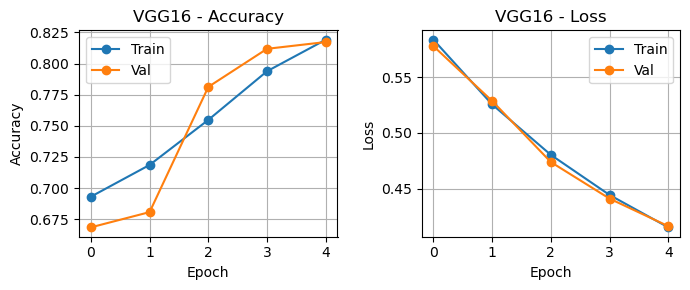

In [1]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Set image size and dataset paths
IMG_SIZE = (240, 240)
cancer_path = r"C:\Users\pc\Downloads\kidney-cancer\kidney-Mri\Dataset\Cancer"
normal_path = r"C:\Users\pc\Downloads\kidney-cancer\kidney-Mri\Dataset\Normal"

# Load and preprocess images
X = []
y = []

def load_images_from_folder(folder, label):
    for filename in os.listdir(folder):
        path = os.path.join(folder, filename)
        img = cv2.imread(path)
        if img is not None:
            img = cv2.resize(img, IMG_SIZE)
            img = img / 255.0  # normalize
            X.append(img)
            y.append(label)

load_images_from_folder(cancer_path, 1)
load_images_from_folder(normal_path, 0)

X = np.array(X)
y = np.array(y)

# Split dataset
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Build VGG16 model
def build_vgg16_model(input_shape):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    for layer in base_model.layers:
        layer.trainable = False
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=x)
    return model

# Compile
vgg_model = build_vgg16_model((240, 240, 3))
vgg_model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Train
vgg_history = vgg_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=5,
    batch_size=32
)

# Evaluate
loss_vgg, acc_vgg = vgg_model.evaluate(X_val, y_val)
print(f"VGG16 Accuracy: {acc_vgg:.4f} | Loss: {loss_vgg:.4f}")

# Plot accuracy and loss
plt.figure(figsize=(7, 3))

plt.subplot(1, 2, 1)
plt.plot(vgg_history.history['accuracy'], marker='o', label='Train')
plt.plot(vgg_history.history['val_accuracy'], marker='o', label='Val')
plt.title('VGG16 - Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(vgg_history.history['loss'], marker='o', label='Train')
plt.plot(vgg_history.history['val_loss'], marker='o', label='Val')
plt.title('VGG16 - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [2]:
vgg_model.save(r"C:\Users\pc\Desktop\models\vgg16-kidney.keras")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


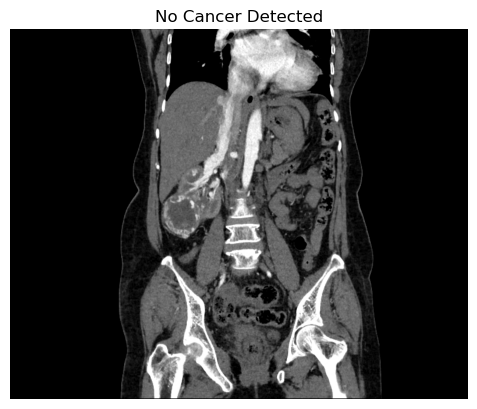

Prediction: No Cancer (Probability: 0.33)


In [3]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
import imutils
from tensorflow.keras.models import load_model
from tkinter import Tk, filedialog

def preprocess_image(image_path, img_size=(240, 240)):
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError("Error loading image. Ensure the file is valid.")

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)

    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])

    image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]
    image = cv2.resize(image, img_size)
    image = image / 255.0

    return image

def test_image(model_path):
    model = load_model(model_path)

    Tk().withdraw()
    image_path = filedialog.askopenfilename(title="Select an MRI Image", filetypes=[("Image Files", "*.jpg;*.png;*.jpeg")])

    if not image_path:
        print("No image selected.")
        return

    image = preprocess_image(image_path)
    image = np.expand_dims(image, axis=0)

    prediction = model.predict(image)[0][0]
    result = "Cancer Detected" if prediction >= 0.5 else "No Cancer Detected"

    plt.imshow(cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB))
    plt.title(result)
    plt.axis('off')
    plt.show()

    print(f"Prediction: {'Cancer' if prediction > 0.5 else 'No Cancer'} (Probability: {prediction:.2f})")
    
#Example Usage
if __name__ == "__main__":
    test_image(r'C:\Users\pc\Desktop\models\vgg16-kidney.keras')


C:\Users\pc\AppData\Local\Temp\ipykernel_8208\3904293142.py:41: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)


Epoch 1/5
184/184 ━━━━━━━━━━━━━━━━━━━━ 255s 943ms/step - accuracy: 0.7355 - loss: 0.5524 - val_accuracy: 0.9083 - val_loss: 0.2830
Epoch 2/5
184/184 ━━━━━━━━━━━━━━━━━━━━ 139s 755ms/step - accuracy: 0.9145 - loss: 0.2506 - val_accuracy: 0.9545 - val_loss: 0.1899
Epoch 3/5
184/184 ━━━━━━━━━━━━━━━━━━━━ 140s 762ms/step - accuracy: 0.9486 - loss: 0.1780 - val_accuracy: 0.9701 - val_loss: 0.1444
Epoch 4/5
184/184 ━━━━━━━━━━━━━━━━━━━━ 137s 745ms/step - accuracy: 0.9688 - loss: 0.1327 - val_accuracy: 0.9755 - val_loss: 0.1170
Epoch 5/5
184/184 ━━━━━━━━━━━━━━━━━━━━ 139s 755ms/step - accuracy: 0.9800 - loss: 0.1066 - val_accuracy: 0.9844 - val_loss: 0.1020
46/46 ━━━━━━━━━━━━━━━━━━━━ 29s 631ms/step - accuracy: 0.9865 - loss: 0.0987
MobileNetV2 Accuracy: 0.9844 | Loss: 0.1020


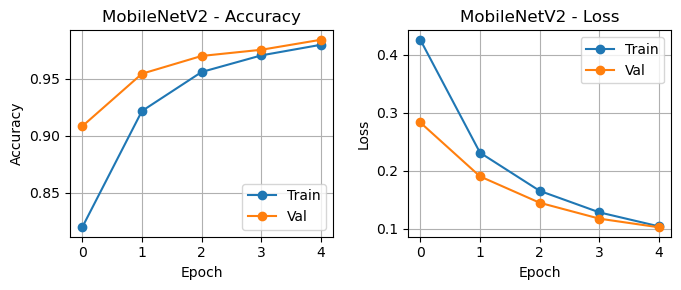

In [19]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Image and folder settings
IMG_SIZE = (240, 240)
cancer_path = r"C:\Users\pc\Downloads\kidney-cancer\kidney-Mri\Dataset\Cancer"
normal_path = r"C:\Users\pc\Downloads\kidney-cancer\kidney-Mri\Dataset\Normal"

# Load dataset
X = []
y = []

def load_images_from_folder(folder, label):
    for filename in os.listdir(folder):
        path = os.path.join(folder, filename)
        img = cv2.imread(path)
        if img is not None:
            img = cv2.resize(img, IMG_SIZE)
            img = img / 255.0
            X.append(img)
            y.append(label)

load_images_from_folder(cancer_path, 1)
load_images_from_folder(normal_path, 0)

X = np.array(X)
y = np.array(y)

# Split into training and validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Build MobileNetV2
def build_mobilenet_model(input_shape):
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
    for layer in base_model.layers:
        layer.trainable = False
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=x)
    return model

# Compile
mobilenet_model = build_mobilenet_model((240, 240, 3))
mobilenet_model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Train
mobilenet_history = mobilenet_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=5,
    batch_size=32
)

# Evaluate
loss_mob, acc_mob = mobilenet_model.evaluate(X_val, y_val)
print(f"MobileNetV2 Accuracy: {acc_mob:.4f} | Loss: {loss_mob:.4f}")

# Plot accuracy and loss
plt.figure(figsize=(7, 3))

plt.subplot(1, 2, 1)
plt.plot(mobilenet_history.history['accuracy'], marker='o', label='Train')
plt.plot(mobilenet_history.history['val_accuracy'], marker='o', label='Val')
plt.title('MobileNetV2 - Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(mobilenet_history.history['loss'], marker='o', label='Train')
plt.plot(mobilenet_history.history['val_loss'], marker='o', label='Val')
plt.title('MobileNetV2 - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [20]:
mobilenet_model.save(r"C:\Users\pc\Desktop\models\mobilenet-kidney.keras")


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


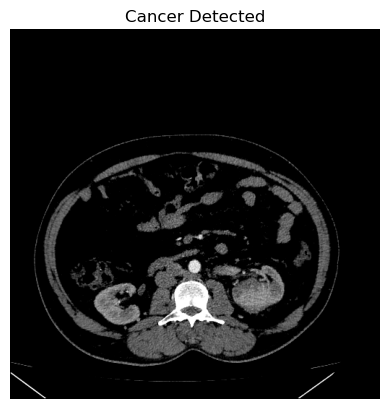

Prediction: Cancer (Probability: 0.90)


In [21]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
import imutils
from tensorflow.keras.models import load_model
from tkinter import Tk, filedialog

def preprocess_image(image_path, img_size=(240, 240)):
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError("Error loading image. Ensure the file is valid.")

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)

    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])

    image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]
    image = cv2.resize(image, img_size)
    image = image / 255.0

    return image

def test_image(model_path):
    model = load_model(model_path)

    Tk().withdraw()
    image_path = filedialog.askopenfilename(title="Select an MRI Image", filetypes=[("Image Files", "*.jpg;*.png;*.jpeg")])

    if not image_path:
        print("No image selected.")
        return

    image = preprocess_image(image_path)
    image = np.expand_dims(image, axis=0)

    prediction = model.predict(image)[0][0]
    result = "Cancer Detected" if prediction >= 0.5 else "No Cancer Detected"

    plt.imshow(cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB))
    plt.title(result)
    plt.axis('off')
    plt.show()

    print(f"Prediction: {'Cancer' if prediction > 0.5 else 'No Cancer'} (Probability: {prediction:.2f})")
    
#Example Usage
if __name__ == "__main__":
    test_image(r"C:\Users\pc\Desktop\models\mobilenet-kidney.keras")


Epoch 1/5
184/184 ━━━━━━━━━━━━━━━━━━━━ 663s 3s/step - accuracy: 0.7033 - loss: 0.5927 - val_accuracy: 0.8458 - val_loss: 0.4044
Epoch 2/5
184/184 ━━━━━━━━━━━━━━━━━━━━ 579s 3s/step - accuracy: 0.8568 - loss: 0.3558 - val_accuracy: 0.8845 - val_loss: 0.3045
Epoch 3/5
184/184 ━━━━━━━━━━━━━━━━━━━━ 580s 3s/step - accuracy: 0.9057 - loss: 0.2743 - val_accuracy: 0.9212 - val_loss: 0.2565
Epoch 4/5
184/184 ━━━━━━━━━━━━━━━━━━━━ 578s 3s/step - accuracy: 0.9294 - loss: 0.2315 - val_accuracy: 0.8981 - val_loss: 0.2407
Epoch 5/5
184/184 ━━━━━━━━━━━━━━━━━━━━ 580s 3s/step - accuracy: 0.9412 - loss: 0.2045 - val_accuracy: 0.9443 - val_loss: 0.2013
46/46 ━━━━━━━━━━━━━━━━━━━━ 118s 3s/step - accuracy: 0.9485 - loss: 0.1960
DenseNet121 Accuracy: 0.9443 | Loss: 0.2013


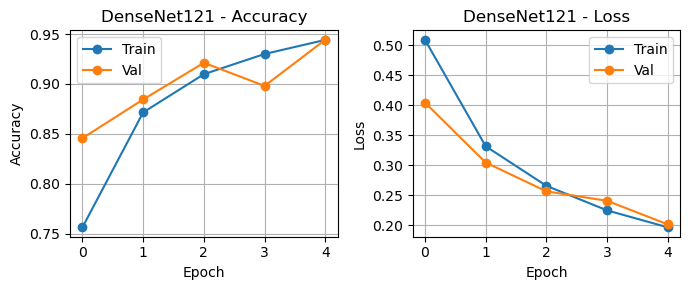

In [1]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Set image size and paths
IMG_SIZE = (240, 240)
cancer_path = r"C:\Users\pc\Downloads\kidney-cancer\kidney-Mri\Dataset\Cancer"
normal_path = r"C:\Users\pc\Downloads\kidney-cancer\kidney-Mri\Dataset\Normal"

# Load images and labels
X = []
y = []

def load_images_from_folder(folder, label):
    for filename in os.listdir(folder):
        path = os.path.join(folder, filename)
        img = cv2.imread(path)
        if img is not None:
            img = cv2.resize(img, IMG_SIZE)
            img = img / 255.0  # normalize
            X.append(img)
            y.append(label)

load_images_from_folder(cancer_path, 1)
load_images_from_folder(normal_path, 0)

X = np.array(X)
y = np.array(y)

# Split the dataset
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Build DenseNet model
def build_densenet_model(input_shape):
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)
    for layer in base_model.layers:
        layer.trainable = False
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=x)
    return model

# Compile
densenet_model = build_densenet_model((240, 240, 3))
densenet_model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Train
densenet_history = densenet_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=5,
    batch_size=32
)

# Evaluate
loss_dense, acc_dense = densenet_model.evaluate(X_val, y_val)
print(f"DenseNet121 Accuracy: {acc_dense:.4f} | Loss: {loss_dense:.4f}")

# Plot
plt.figure(figsize=(7, 3))

plt.subplot(1, 2, 1)
plt.plot(densenet_history.history['accuracy'], marker='o', label='Train')
plt.plot(densenet_history.history['val_accuracy'], marker='o', label='Val')
plt.title('DenseNet121 - Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(densenet_history.history['loss'], marker='o', label='Train')
plt.plot(densenet_history.history['val_loss'], marker='o', label='Val') 
plt.title('DenseNet121 - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [2]:
densenet_model.save(r"C:\Users\pc\Desktop\models\densenet-kidney.keras")


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


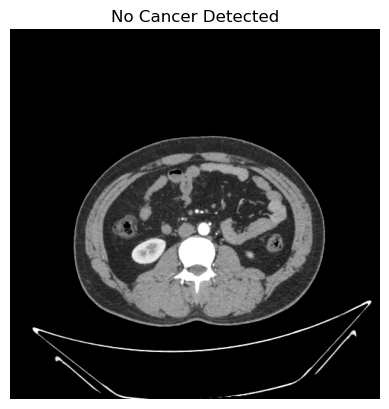

Prediction: No Cancer (Probability: 0.03)


In [3]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
import imutils
from tensorflow.keras.models import load_model
from tkinter import Tk, filedialog

def preprocess_image(image_path, img_size=(240, 240)):
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError("Error loading image. Ensure the file is valid.")

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)

    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])

    image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]
    image = cv2.resize(image, img_size)
    image = image / 255.0

    return image

def test_image(model_path):
    model = load_model(model_path)

    Tk().withdraw()
    image_path = filedialog.askopenfilename(title="Select an MRI Image", filetypes=[("Image Files", "*.jpg;*.png;*.jpeg")])

    if not image_path:
        print("No image selected.")
        return

    image = preprocess_image(image_path)
    image = np.expand_dims(image, axis=0)

    prediction = model.predict(image)[0][0]
    result = "Cancer Detected" if prediction >= 0.5 else "No Cancer Detected"

    plt.imshow(cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB))
    plt.title(result)
    plt.axis('off')
    plt.show()

    print(f"Prediction: {'Cancer' if prediction > 0.5 else 'No Cancer'} (Probability: {prediction:.2f})")
    
#Example Usage
if __name__ == "__main__":
    test_image(r"C:\Users\pc\Desktop\models\densenet-kidney.keras")


Epoch 1/5
184/184 ━━━━━━━━━━━━━━━━━━━━ 334s 1s/step - accuracy: 0.6904 - loss: 0.6223 - val_accuracy: 0.6678 - val_loss: 0.6359
Epoch 2/5
184/184 ━━━━━━━━━━━━━━━━━━━━ 197s 1s/step - accuracy: 0.6977 - loss: 0.6156 - val_accuracy: 0.6678 - val_loss: 0.6359
Epoch 3/5
184/184 ━━━━━━━━━━━━━━━━━━━━ 196s 1s/step - accuracy: 0.7079 - loss: 0.6064 - val_accuracy: 0.6678 - val_loss: 0.6467
Epoch 4/5
184/184 ━━━━━━━━━━━━━━━━━━━━ 195s 1s/step - accuracy: 0.6893 - loss: 0.6222 - val_accuracy: 0.6678 - val_loss: 0.6457
Epoch 5/5
184/184 ━━━━━━━━━━━━━━━━━━━━ 203s 1s/step - accuracy: 0.7061 - loss: 0.6085 - val_accuracy: 0.6678 - val_loss: 0.6376
46/46 ━━━━━━━━━━━━━━━━━━━━ 42s 912ms/step - accuracy: 0.6602 - loss: 0.6419
EfficientNetB0 Accuracy: 0.6678 | Loss: 0.6376


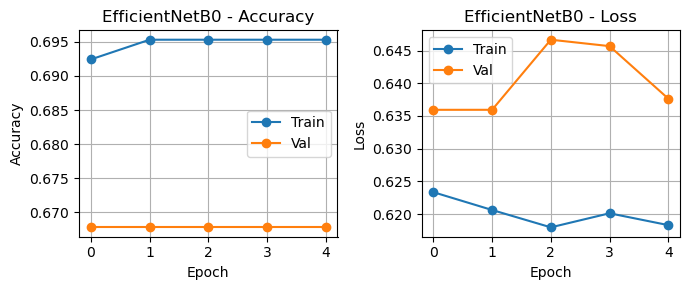

In [4]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Set image size and paths
IMG_SIZE = (240, 240)
cancer_path = r"C:\Users\pc\Downloads\kidney-cancer\kidney-Mri\Dataset\Cancer"
normal_path = r"C:\Users\pc\Downloads\kidney-cancer\kidney-Mri\Dataset\Normal"

# Load images
X = []
y = []

def load_images_from_folder(folder, label):
    for filename in os.listdir(folder):
        path = os.path.join(folder, filename)
        img = cv2.imread(path)
        if img is not None:
            img = cv2.resize(img, IMG_SIZE)
            img = img / 255.0  # Normalize
            X.append(img)
            y.append(label)

load_images_from_folder(cancer_path, 1)
load_images_from_folder(normal_path, 0)

X = np.array(X)
y = np.array(y)

# Train/validation split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Build EfficientNetB0
def build_efficientnet_model(input_shape):
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=input_shape)
    for layer in base_model.layers:
        layer.trainable = False
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=x)
    return model

# Compile
efficientnet_model = build_efficientnet_model((240, 240, 3))
efficientnet_model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

# Train
efficientnet_history = efficientnet_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=5,
    batch_size=32
)

# Evaluate
loss_eff, acc_eff = efficientnet_model.evaluate(X_val, y_val)
print(f"EfficientNetB0 Accuracy: {acc_eff:.4f} | Loss: {loss_eff:.4f}")

# Plot results
plt.figure(figsize=(7, 3))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(efficientnet_history.history['accuracy'], marker='o', label='Train')
plt.plot(efficientnet_history.history['val_accuracy'], marker='o', label='Val')
plt.title('EfficientNetB0 - Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(efficientnet_history.history['loss'], marker='o', label='Train')
plt.plot(efficientnet_history.history['val_loss'], marker='o', label='Val')
plt.title('EfficientNetB0 - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [5]:
efficientnet_model.save(r"C:\Users\pc\Desktop\models\efficientnet-kidney.keras")

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


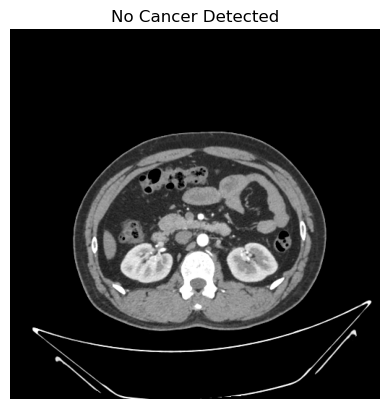

Prediction: No Cancer (Probability: 0.36)


In [6]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
import imutils
from tensorflow.keras.models import load_model
from tkinter import Tk, filedialog

def preprocess_image(image_path, img_size=(240, 240)):
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError("Error loading image. Ensure the file is valid.")

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)

    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])

    image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]
    image = cv2.resize(image, img_size)
    image = image / 255.0

    return image

def test_image(model_path):
    model = load_model(model_path)

    Tk().withdraw()
    image_path = filedialog.askopenfilename(title="Select an MRI Image", filetypes=[("Image Files", "*.jpg;*.png;*.jpeg")])

    if not image_path:
        print("No image selected.")
        return

    image = preprocess_image(image_path)
    image = np.expand_dims(image, axis=0)

    prediction = model.predict(image)[0][0]
    result = "Cancer Detected" if prediction >= 0.5 else "No Cancer Detected"

    plt.imshow(cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB))
    plt.title(result)
    plt.axis('off')
    plt.show()

    print(f"Prediction: {'Cancer' if prediction > 0.5 else 'No Cancer'} (Probability: {prediction:.2f})")
    
#Example Usage
if __name__ == "__main__":
    test_image(r"C:\Users\pc\Desktop\models\efficientnet-kidney.keras")


In [7]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Set image size and dataset paths
IMG_SIZE = (240, 240)
cancer_path = r"C:\Users\pc\Downloads\kidney-cancer\kidney-Mri\Dataset\Cancer"
normal_path = r"C:\Users\pc\Downloads\kidney-cancer\kidney-Mri\Dataset\Normal"

# Load and preprocess images
X = []
y = []

def load_images_from_folder(folder, label):
    for filename in os.listdir(folder):
        path = os.path.join(folder, filename)
        img = cv2.imread(path)
        if img is not None:
            img = cv2.resize(img, IMG_SIZE)
            img = img / 255.0  # normalize
            X.append(img)
            y.append(label)

load_images_from_folder(cancer_path, 1)
load_images_from_folder(normal_path, 0)

X = np.array(X)
y = np.array(y)


In [8]:

# Split into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:

# Build ResNet50 model
def build_resnet_model(input_shape):
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    for layer in base_model.layers:
        layer.trainable = False
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=x)
    return model

In [10]:
# Compile model
resnet_model = build_resnet_model((240, 240, 3))
resnet_model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])


In [11]:
# Train model
resnet_history = resnet_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=5,
    batch_size=32
)

Epoch 1/5
184/184 ━━━━━━━━━━━━━━━━━━━━ 958s 5s/step - accuracy: 0.6642 - loss: 0.6127 - val_accuracy: 0.6766 - val_loss: 0.5386
Epoch 2/5
184/184 ━━━━━━━━━━━━━━━━━━━━ 721s 4s/step - accuracy: 0.7088 - loss: 0.5140 - val_accuracy: 0.7018 - val_loss: 0.4966
Epoch 3/5
184/184 ━━━━━━━━━━━━━━━━━━━━ 722s 4s/step - accuracy: 0.7593 - loss: 0.4676 - val_accuracy: 0.7615 - val_loss: 0.4488
Epoch 4/5
184/184 ━━━━━━━━━━━━━━━━━━━━ 724s 4s/step - accuracy: 0.7960 - loss: 0.4302 - val_accuracy: 0.8424 - val_loss: 0.4149
Epoch 5/5
184/184 ━━━━━━━━━━━━━━━━━━━━ 722s 4s/step - accuracy: 0.8305 - loss: 0.4019 - val_accuracy: 0.8580 - val_loss: 0.3943


In [12]:
resnet_model.save(r"C:\Users\pc\Desktop\models\resnet-kidney.keras")

46/46 ━━━━━━━━━━━━━━━━━━━━ 144s 3s/step - accuracy: 0.8701 - loss: 0.3871
ResNet50 Accuracy: 0.8580 | Loss: 0.3943


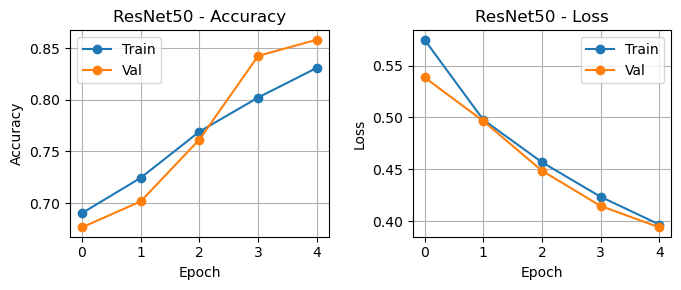

In [13]:
# Evaluate model
loss_res, acc_res = resnet_model.evaluate(X_val, y_val)
print(f"ResNet50 Accuracy: {acc_res:.4f} | Loss: {loss_res:.4f}")

# Plot accuracy and loss
plt.figure(figsize=(7, 3))

plt.subplot(1, 2, 1)
plt.plot(resnet_history.history['accuracy'], marker='o', label='Train')
plt.plot(resnet_history.history['val_accuracy'], marker='o', label='Val')
plt.title('ResNet50 - Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(resnet_history.history['loss'], marker='o', label='Train')
plt.plot(resnet_history.history['val_loss'], marker='o', label='Val')
plt.title('ResNet50 - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


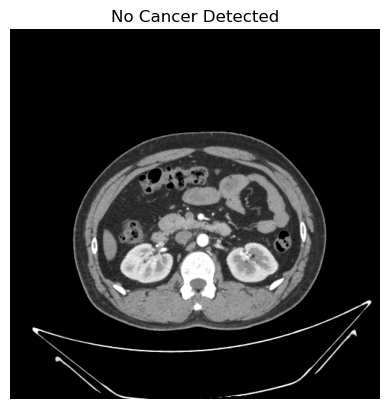

Prediction: No Cancer (Probability: 0.29)


In [14]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
import imutils
from tensorflow.keras.models import load_model
from tkinter import Tk, filedialog

def preprocess_image(image_path, img_size=(240, 240)):
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError("Error loading image. Ensure the file is valid.")

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)

    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])

    image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]
    image = cv2.resize(image, img_size)
    image = image / 255.0

    return image

def test_image(model_path):
    model = load_model(model_path)

    Tk().withdraw()
    image_path = filedialog.askopenfilename(title="Select an MRI Image", filetypes=[("Image Files", "*.jpg;*.png;*.jpeg")])

    if not image_path:
        print("No image selected.")
        return

    image = preprocess_image(image_path)
    image = np.expand_dims(image, axis=0)

    prediction = model.predict(image)[0][0]
    result = "Cancer Detected" if prediction >= 0.5 else "No Cancer Detected"

    plt.imshow(cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB))
    plt.title(result)
    plt.axis('off')
    plt.show()

    print(f"Prediction: {'Cancer' if prediction > 0.5 else 'No Cancer'} (Probability: {prediction:.2f})")
    
#Example Usage
if __name__ == "__main__":
    test_image(r"C:\Users\pc\Desktop\models\resnet-kidney.keras")
